In [7]:
import pandas as pd
%matplotlib inline
import re
import sys
import time
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from __future__ import unicode_literals

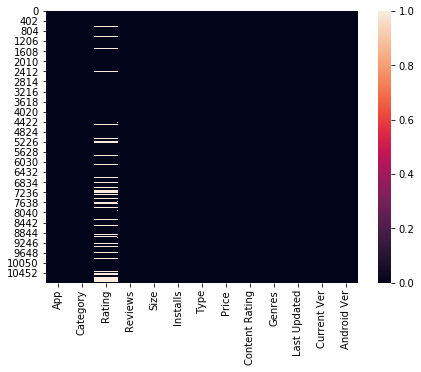

In [8]:
"""
Data Loading & Data Cleaning
"""
data = pd.read_csv("googleplaystore.csv",encoding='utf-8')
data.isnull().sum()
data.isnull().any()
plt.figure(figsize=(7, 5))
sns.heatmap(data.isnull())
data.isnull().any()

data['Rating'] = data['Rating'].fillna(data['Rating'].median())
data['Current Ver'] = data['Current Ver'].replace('Varies with device',np.nan)
data['Current Ver'] = data['Current Ver'].fillna(data['Current Ver'].mode()[0])

# Count number of unique values in category column 
data['Category'].unique()

# Removing NaN values
data = data[pd.notnull(data['Last Updated'])]
data = data[pd.notnull(data['Content Rating'])]

# This is to be anomaly record.
i = data[data['Category'] == '1.9'].index
data.loc[i]
# Drop the anomaly record
data = data.drop(i)

## Feature Engineering

In [9]:
# App values encoding
le = preprocessing.LabelEncoder()
data['App'] = le.fit_transform(data['App'])

# Category features encoding

category_list = data['Category'].unique().tolist() 
category_list = ['cat_' + word for word in category_list]
category_list
data = pd.concat([data, pd.get_dummies(data['Category'], prefix='cat')], axis=1)

# Genres features encoding
le = preprocessing.LabelEncoder()
data['Genres'] = le.fit_transform(data['Genres'])

# Encode Content Rating features
le = preprocessing.LabelEncoder()
data['Content Rating'] = le.fit_transform(data['Content Rating'])

# Price cleaning
data['Price'] = data['Price'].apply(lambda x : x.strip('$'))
# Installs cleaning
data['Installs'] = data['Installs'].apply(lambda x : x.strip('+').replace(',', ''))

# Type encoding
data['Type'] = pd.get_dummies(data['Type'])

# Last Updated encoding
data['Last Updated'] = data['Last Updated'].apply(lambda x : time.mktime(datetime.datetime.strptime(x, '%B %d, %Y').timetuple()))


# Convert kbytes to mbytes 
k_indices = data['Size'].loc[data['Size'].str.contains('k')].index.tolist()
converter = pd.DataFrame(data.loc[k_indices, 'Size'].apply(lambda x: x.strip('k')).astype(float).apply(lambda x: x / 1024).apply(lambda x: round(x, 3)).astype(str))
data.loc[k_indices,'Size'] = converter

# Size cleaning
data['Size'] = data['Size'].apply(lambda x: x.strip('M'))
data[data['Size'] == 'Varies with device'] = 0
data['Size'] = data['Size'].astype(float)
data

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,...,cat_PERSONALIZATION,cat_PHOTOGRAPHY,cat_PRODUCTIVITY,cat_SHOPPING,cat_SOCIAL,cat_SPORTS,cat_TOOLS,cat_TRAVEL_AND_LOCAL,cat_VIDEO_PLAYERS,cat_WEATHER
0,6962,ART_AND_DESIGN,4.1,159,19.000,10000,1,0,1,9,...,0,0,0,0,0,0,0,0,0,0
1,2632,ART_AND_DESIGN,3.9,967,14.000,500000,1,0,1,12,...,0,0,0,0,0,0,0,0,0,0
2,8656,ART_AND_DESIGN,4.7,87510,8.700,5000000,1,0,1,9,...,0,0,0,0,0,0,0,0,0,0
3,7827,ART_AND_DESIGN,4.5,215644,25.000,50000000,1,0,4,9,...,0,0,0,0,0,0,0,0,0,0
4,7022,ART_AND_DESIGN,4.3,967,2.800,100000,1,0,1,11,...,0,0,0,0,0,0,0,0,0,0
5,6878,ART_AND_DESIGN,4.4,167,5.600,50000,1,0,1,9,...,0,0,0,0,0,0,0,0,0,0
6,7880,ART_AND_DESIGN,3.8,178,19.000,50000,1,0,1,9,...,0,0,0,0,0,0,0,0,0,0
7,5378,ART_AND_DESIGN,4.1,36815,29.000,1000000,1,0,1,9,...,0,0,0,0,0,0,0,0,0,0
8,4804,ART_AND_DESIGN,4.4,13791,33.000,1000000,1,0,1,9,...,0,0,0,0,0,0,0,0,0,0
9,5591,ART_AND_DESIGN,4.7,121,3.100,10000,1,0,1,11,...,0,0,0,0,0,0,0,0,0,0
